In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib import gridspec

In [2]:
def get_events(tstamp,state, type):
    if type == "UP":
        mask = np.concatenate((np.array([False]),np.logical_and(state[1:]==1,state[1:]!=state[:-1] )))
        events = tstamp[mask]
        return events
    elif type == 'DOWN':
        mask = np.concatenate((np.array([False]),np.logical_and(state[1:]==0,state[1:]!=state[:-1] )))
        events = tstamp[mask]
        return events        
    elif type == "BOTH":
        mask = np.concatenate((np.array([False]),state[1:]!=state[:-1]))
        events = tstamp[mask]
        return events
    else:
        return None

In [3]:
def process_rt_data(fname):
    pps1_events = np.array([])
    pps2_events = np.array([])
    user_events = np.array([])

    data = np.genfromtxt(fname,dtype=float, delimiter=',',skip_header=1)

    raw_ts = data[:,0];
    raw_pps1 = data[:,1];
    raw_pps2 = data[:,2];
    raw_user = data[:,3];

    # delete the first invalid signals
    raw_data = [raw_pps1, raw_pps1, raw_user]

    risings = list(map(lambda l: get_events(raw_ts,l,'UP'), raw_data ));
    fallings = list(map(lambda l: get_events(raw_ts,l,'DOWN'), raw_data ));
    first_rise = min(list(map( lambda l : l[0], risings     )))
    risings = list(map(lambda l: l[l>first_rise - 0.01], risings))
    fallings = list(map(lambda l: l[l>first_rise - 0.01], fallings))

    pps1_up = risings[0];

    last_pps_rise = pps1_up[-1];

    user_up = risings[2];
    user_up = user_up[user_up < last_pps_rise+0.1];
    user_down = fallings[2];
    user_down = user_down[user_down < last_pps_rise+0.1];

    user_start = np.argmin(abs(pps1_up[0] - user_up))
    user_up = user_up[user_start:]
    user_down = user_down[user_start:]

    # pulse around pps rising edge
    user_0  = user_up[0::10]

    user_delay = user_0 - pps1_up;
    print "User delay at the rising PPS edge"
    plot(user_delay*1e6)
    show()

    # interpolate pps to the middle points
    x = range(0,len(pps1_up))
    xuser = np.arange(0,len(user_up))/10.0
    y = pps1_up;
    pps1_up_interp = np.interp(xuser,x,y);

    user_delay_interp = user_up - pps1_up_interp
    print "User delay including the middle points"
    plot(user_delay_interp*1e6,'x-')
    show()

    return user_delay_interp;

def plot_distribution(dist,extra_title):
    dist_max = max(dist)
    dist_min = min(dist)
    dist_mean = np.mean(dist)
    f = figure(figsize=(8,3))
    h_min = np.floor(min(dist)*0.95);
    hist(dist,bins=np.arange(h_min,200,1),edgecolor='k',Color='brown')
    yscale('log')
    title('RT-PATCH latency - %s (rtprio:80)' % extra_title)
    xlabel('Delay [us]')
    ylabel('Count')
    text(140,900,'Max. value:   %.2fusec\nMin. value:   %.2fusec\nMean:   %.2fusec' % (dist_max, dist_min, dist_mean), ha='left', bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5),  fc=(1., 0.8, 0.8)))
    grid()
    show()
    return f;  

User delay at the rising PPS edge


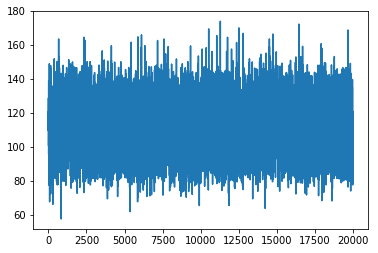

User delay including the middle points


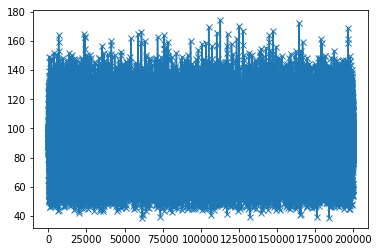

In [9]:
# results with stress
fname = './preempt_rt_data/stress/untitled.csv'
user_delay_stress = process_rt_data(fname)*1e6;

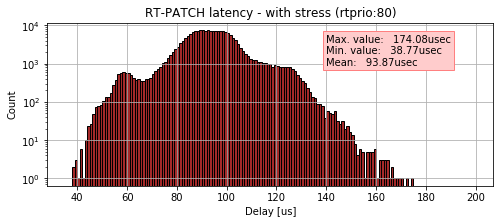

In [6]:
fig = plot_distribution(user_delay_stress, "with stress")
fig.savefig('./preempt_rt_data/rt_stress',bbox_inches = "tight")

User delay at the rising PPS edge


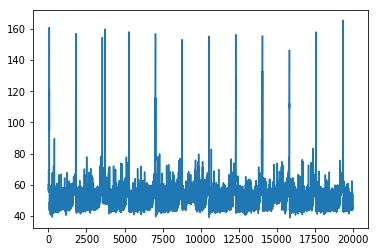

User delay including the middle points


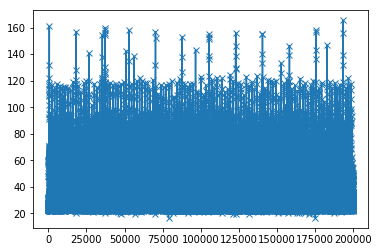

In [4]:
# results without stress
fname = './preempt_rt_data/no-stress/untitled.csv'
user_delay_no_stress = process_rt_data(fname)*1e6;

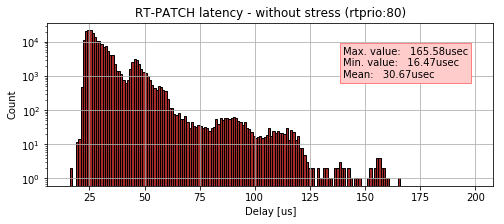

In [8]:
fig = plot_distribution(user_delay_no_stress, "without stress")
fig.savefig('./preempt_rt_data/rt_no_stress',bbox_inches = "tight")

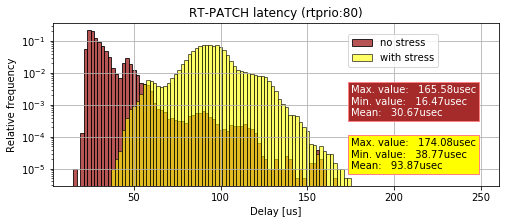

In [178]:
# stress vs no stress mixed plot
dist1 = user_delay_stress;
dist2 = user_delay_no_stress;

dist1_max = max(dist1)
dist1_min = min(dist1)
dist1_mean = np.mean(dist1)

dist2_max = max(dist2)
dist2_min = min(dist2)
dist2_mean = np.mean(dist2)

fig = figure(figsize=(8,3))
h_min = np.floor(min(min(dist1),min(dist2))*0.95);
h_max = 250;
hist(dist2,bins=np.arange(h_min,h_max,2), alpha = 0.8,edgecolor='k',Color='brown',label='no stress',weights=np.zeros_like(dist2) + 1. / dist2.size);
hist(dist1,bins=np.arange(h_min,h_max,2), alpha = 0.6,edgecolor='k',Color='yellow', label='with stress',weights=np.zeros_like(dist1) + 1. / dist1.size);
yscale('log')
title('RT-PATCH latency (rtprio:80)')
xlabel('Delay [us]')
ylabel('Relative frequency')
grid()
legend(loc = 'lower left', bbox_to_anchor=(0.65, 0.7))

text(175,1e-5,'Max. value:   %.2fusec\nMin. value:   %.2fusec\nMean:   %.2fusec' % (dist1_max, dist1_min, dist1_mean), ha='left', bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5),  fc="yellow"))
text(175,0.45e-3,'Max. value:   %.2fusec\nMin. value:   %.2fusec\nMean:   %.2fusec' % (dist2_max, dist2_min, dist2_mean), ha='left', bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5),  fc="brown"),Color = 'white')
show()

fig.savefig('./preempt_rt_data/rt_comp_stress',bbox_inches = "tight")

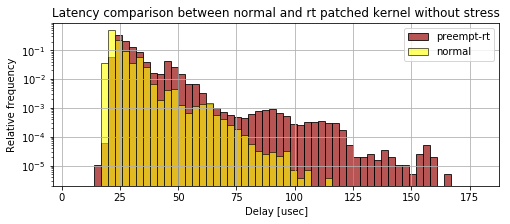

In [65]:
# mixed plot with normal kernel - no_stress

normal_no_stress = np.load('./normal_kernel/no_stress/no_stress.npy');
bins = np.arange(5,180,3);
figure(figsize=(8,3))
hist(user_delay_no_stress, bins = bins, alpha = 0.8,label='preempt-rt',edgecolor='k',Color='brown', weights=np.zeros_like(user_delay_no_stress) + 1. / user_delay_no_stress.size);
hist(normal_no_stress, bins = bins, alpha = 0.6,label='normal',edgecolor='k',Color='yellow',  weights=np.zeros_like(normal_no_stress) + 1. / normal_no_stress.size);
yscale('log');
grid()
title('Latency comparison between normal and rt patched kernel without stress');
xlabel('Delay [usec]')
ylabel('Relative frequency')
legend();
savefig('./preempt_rt_data/rt_vs_normal_no_stress',bbox_inches = "tight");

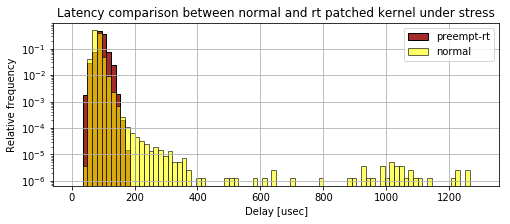

In [64]:
# mixed plot with normal kernel - stress

normal_stress = np.load('./normal_kernel/stress/diff_stress.npy');
bins = np.arange(5,1300,15);
figure(figsize=(8,3))
hist(user_delay_stress, bins = bins, alpha = 1,label='preempt-rt',edgecolor='k',Color='brown', weights=np.zeros_like(user_delay_stress) + 1. / user_delay_stress.size);
hist(normal_stress, bins = bins, alpha = 0.6,label='normal',edgecolor='k',Color='yellow',  weights=np.zeros_like(normal_stress) + 1. / normal_stress.size);
yscale('log');
grid()
title('Latency comparison between normal and rt patched kernel under stress');
xlabel('Delay [usec]')
ylabel('Relative frequency')
legend();
savefig('./preempt_rt_data/rt_vs_normal_stress',bbox_inches = "tight");

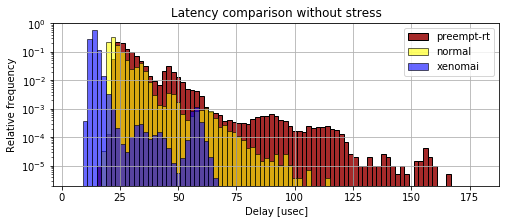

In [60]:
# mixed plot with normal + xenomai - stress
try:
    xeno_no_stress = xeno_no_stress;
except:
    xeno_no_stress = np.load('./XENOMAI/xeno_no_stress.npy');

try:
    normal_no_stress = normal_no_stress;
except:
    normal_no_stress = np.load('./normal_kernel/no_stress/no_stress.npy');

bins = np.arange(5,180,2);
figure(figsize=(8,3))
hist(user_delay_no_stress, bins = bins, alpha = 1,label='preempt-rt',edgecolor='k',Color='brown',weights=np.zeros_like(user_delay_no_stress) + 1. / user_delay_no_stress.size);
hist(normal_no_stress, bins = bins, alpha = 0.6,label='normal',edgecolor='k',Color='yellow',  weights=np.zeros_like(normal_no_stress) + 1. / normal_no_stress.size);
hist(xeno_no_stress, bins = bins, alpha = 0.6,label='xenomai',edgecolor='k',Color='blue', weights=np.zeros_like(xeno_no_stress) + 1. / xeno_no_stress.size);
yscale('log');
grid()
title('Latency comparison without stress');
xlabel('Delay [usec]')
ylabel('Relative frequency')
legend();
savefig('./preempt_rt_data/normal_vs_rt_vs_xeno_no_stress',bbox_inches = "tight");

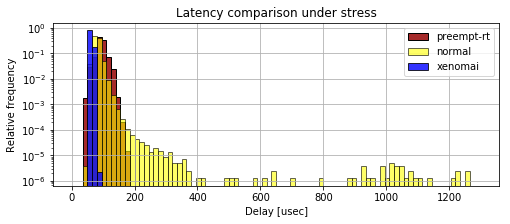

In [62]:
# mixed plot with normal + xenomai - with stress

try:
    xeno_stress = xeno_stress;
except:
    xeno_stress = np.load('./XENOMAI/xeno_stress.npy');

try:
    normal_stress = normal_stress;
except:
    normal_stress = np.load('./normal_kernel/stress/diff_stress.npy');
    

bins = np.arange(5,1300,15);
figure(figsize=(8,3))
hist(user_delay_stress, bins = bins, alpha = 1,label='preempt-rt',edgecolor='k',Color='brown', weights=np.zeros_like(user_delay_stress) + 1. / user_delay_stress.size);
hist(normal_stress, bins = bins, alpha = 0.6,label='normal',edgecolor='k',Color='yellow',  weights=np.zeros_like(normal_stress) + 1. / normal_stress.size);
hist(xeno_stress, bins = bins, alpha = 0.8,label='xenomai',edgecolor='k',Color='blue',  weights=np.zeros_like(xeno_stress) + 1. / xeno_stress.size);
yscale('log');
grid()
title('Latency comparison under stress');
xlabel('Delay [usec]')
ylabel('Relative frequency')
legend();
savefig('./preempt_rt_data/normal_vs_rt_vs_xeno_stress',bbox_inches = "tight");

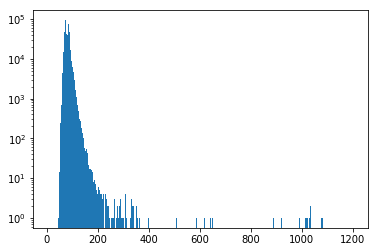

In [73]:
bins = np.arange(5,1200,2);
hist(normal_stress,bins = bins)
yscale('log')

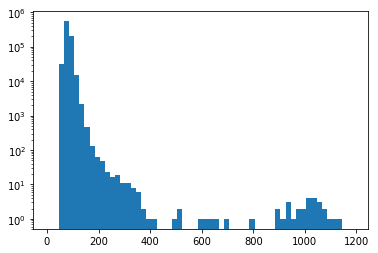

In [74]:
bins = np.arange(5,1200,20);
hist(normal_stress,bins = bins)
yscale('log')